# In class exercise...Mutual Information 11.22.2021

## Imports

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score

## To better understand the systematic relationship between entropy and the predictability of outcomes, consider the case of biased coin flips.
* In class we did an example with an unbiased coin
* This situation has an entropy of 1 bit, because each outcome (0 or 1) is equally likely
* Here, consider a case where you systematically vary the bias in a coin from 0 (always tails) to 1 (always heads)
* Plot the resulting entropy function over approximately 1000 steps (or a lot of steps) in between a bias of 0 and 1
    * note: actually go from a bias of .001 to .999 because log2(0) = -inf and log2(1) = 0, so start right above zero and go up to right below 1
    * to do this, you might start by defining a variable names "ph" (prob of heads) and then use np.arange to initialize it so that you can specify the start point, stop point, and step size (and np.arange can have floating point step sizes of .001 or whatever you'd like)
    
* try writing out the formula for entropy on your own (as opposed to using scipy.stats.entropy or some other package)

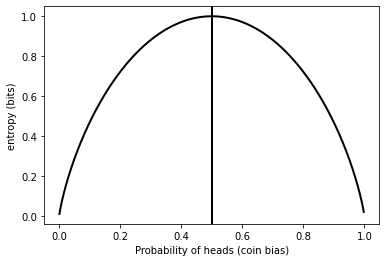

In [11]:
# number of outcomes (e.g. heads or tails)
n = 2  

# vary the probability of heads
ph = np.arange(.001,.999,.001)  

# alloc to store entropy at each probability
H = np.zeros(len(ph))

# alloc array to store px's at each level of 
px = np.zeros(2)

# loop over all ph's 
for j in np.arange(len(ph)):
    px[0] = ph[j]    # p(heads)
    px[1] = 1-px[0]  # p(tails)
    
    # then compute entropy
    for i in np.arange(n):
        H[j] += -( px[i] * np.log2(px[i]) )
        
#     H[j] = np.sum(px * np.log2(px))
    
    
plt.plot(ph, H, 'k', linewidth=2)
plt.xlabel('Probability of heads (coin bias)')
plt.ylabel('entropy (bits)')
plt.axvline(.5, color='k', linewidth=2)
plt.show()
# entropy is maximized with maximum uncertainty and will max out at
# log2(n)

## Load in the eeg data from previous tutorials...

In [12]:
# load the data...
eeg = np.load('eeg_data01.npz')

# get the different arrays like this...kind of like a structure in matlab. 
eeg['data']
eeg['sr']
eeg['tx']

# and can query the attributes of the data like this...which will tell us that there 1600 trials and 4102 timepoints per trial sampled
# at 1024Hz
print('Shape of the big eeg data set: ', eeg['data'].shape)
print('Sample rate: ', eeg['sr'])

# and if you want to save some typing, especially because we only have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']

Shape of the big eeg data set:  (1600, 4102)
Sample rate:  1024


## Make a vector that labels each trial as coming from experimental conditions 1,2,3,4

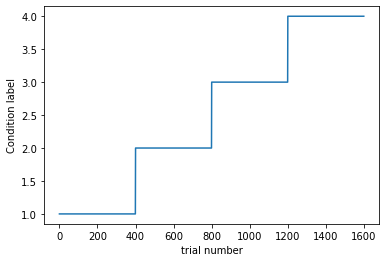

In [16]:
N = data.shape[0]
num_samp_cond = int(N/4)
cond = np.hstack((np.ones(num_samp_cond), 
                  np.ones(num_samp_cond)*2, np.ones(num_samp_cond)*3, np.ones(num_samp_cond)*4))

plt.plot(cond)
plt.xlabel('trial number')
plt.ylabel('Condition label')
plt.show()


## Now avgerage the data from condition 2, avg the data from condition 3, and plot against the time axis (tx) - we're going to ignore conditions 1 and 4

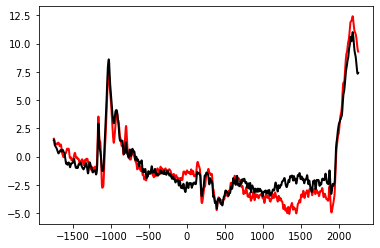

In [24]:
avg1 = np.mean(data[cond==2,:], axis=0)
avg2 = np.mean(data[cond==3,:], axis=0)

plt.plot(tx, avg1, color='r', linewidth=2)
plt.plot(tx, avg2, color='k', linewidth=2)
plt.show()

## Then compute the MI between evoked responses and experimental condition in a specific time window from 1000ms to 1500ms post-stimulus onset (so >= 1000 and <1500)
* You have one discrete variable (cond, or experimental condition label)
* You have the EEG data from each condition, which is a continuous variable
* First compute the mean response across the time window for each trial of condition 2. This should give you a 400 element array with the mean from each trial across the time window. 
* Then compute the mean response across the time window for each trial of condition 3. 
* Then concatenate the two 400 element arrays to make one 800 element array
* You might also want to create a new set of labels for each trial in your new concatenated array - can relabel conds 2 and 3 with a 0 and 1 for ease of looping...so it would have 400 0's followed by 400 1's
* Use only 10 bins for discretizing the continuous EEG data...
* Then compute the MI between experimental condition and EEG responses

#### first compute means over time window for conds 2 and 3, stack up...

In [40]:
# get the data from the time window...
td = data[:, (tx>=1000) & (tx<1500)]

# just data from cond 2, meaned across time window
td2 = np.mean(td[cond==2,:], axis=1)
td3 = np.mean(td[cond==3,:], axis=1)

# concatenate
resp = np.hstack((td2, td3))

# check the size to be sure we did this right...
resp.shape

(800,)

#### then make new labels...400 zeros stacked on top of 400 ones

In [41]:
# make a new set of labels

# first 1/2 of the data came from condition 1, second half from condition 2

# ntrials in each condition
ntrials = int(resp.shape[0]/2)

stims = np.hstack((np.zeros(ntrials),np.ones(ntrials)))

# check the shape
stims.shape

(800,)

#### now compute MI!

In [44]:
# how many bins? 
nbins = 10

# first bin the data using histogram. 
# however, just save the edges of each bin
_, edges = np.histogram(resp, bins=nbins)

# then sort all of the continuous responses in bins
# use numpy digitize...you pass in the continuous 
# response and the bin edges and it will sort each 
# response into the appropriate bin
bin_y = np.digitize(resp, edges)

# then compute MI! note that stims is a N x 1 array (2D)
# and mutual_info_score requires a 1D array so I am 
# "squeezing" out the the singular dim to make it a N, array (1D) 
MI = mutual_info_score(np.squeeze(stims),bin_y) * np.log2(np.e)

print(MI)

0.023407581578854086


## 